# Tutorial 6 - Stable Baselines3 Demo

Few things about Stable Baselines3:
* [stable-baselines3](https://github.com/DLR-RM/stable-baselines3) contains the core algorithms.
* [rl-baselines3-zoo](https://github.com/DLR-RM/rl-baselines3-zoo) contains additional scripts for training, evaluation, tuning and recording.
* [Documentation](https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html.) 
* [Additional Tutorials](https://github.com/araffin/rl-tutorial-jnrr19?tab=readme-ov-file)

In [1]:
# Install dependencies
# pip install stable-baselines3[extra]
#!apt-get update && apt-get install swig cmake
#!pip install box2d-py
#!pip install "stable-baselines3[extra]>=2.0.0a4"

### Demo - Playing Donkey Kong using DQN

Suppose that we have to design a RL agent to play the atari variant of [Donkey Kong](https://gymnasium.farama.org/environments/atari/donkey_kong/). The following information is given:

| Information        | Value                       |
|--------------------|-----------------------------|
| Action Space       | Discrete(18)                |
| Observation Space  | Box(0, 255, (210, 160, 3), uint8) |
| Import             | `gymnasium.make("ALE/DonkeyKong-v5")` |

[Deep Q-learning](https://en.wikipedia.org/wiki/Q-learning) was originally demonstrated as working directly with frames from atari games (the state space are images from the game). This is made possible because the action value function $q(s,a, \mathbf{w})$ is approximated using a convolutional neural network (CNN), which naturally handles image data. Of course, DQN can also be used with other function approximators. But when using a Multilayer Perceptron (MLP) for example, feature vectors have to be used.

Deep Q-learning can be seen as an extension of Q-learning. As in Q-learning $\epsilon$-greedy action selection is used for exploration and the target is a deterministic greedy policy:
$$
    \pi_*(s) = \underset{a \in \mathcal{A}}{\text{argmax}} \; q_*(s,a).
$$
Just like Q-learning, DQN is not compatible with continuous action spaces. As can be seen from the stable-baselines3 documentation on which gymnasium space is supported:

| Space            | Action     | Observation |
|------------------|------------|-------------|
| Discrete         | ✔️          | ✔️          |
| Box              | ❌          | ✔️          |
| MultiDiscrete    | ❌          | ✔️          |
| MultiBinary      | ❌          | ✔️          |
| Dict             | ❌          | ✔️          |




In [1]:
import gymnasium as gym
import os
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.env_util import make_atari_env

First, we want to do some common pre-processing that is done on atari environments. This is done with the `make_atari_env` function + the `VecFrameStack` wrapper. The pre-processing steps are:
* Noop reset: obtain initial state by taking random number of no-ops on reset.
* Frame skipping: 4 by default.
* Max-pooling: most recent two observations.
* Termination signal when a life is lost.
* Resize to a square image: 84x84 by default.
* Grayscale observation.
* Clip reward to $\{-1, 0, 1\}$.
* Stack multiple frames together to provide the agent with temporal information.

So the input to our CNN which approximates the action-value function are 4 pre-processed $84 \times 84$ frames from the game.

In [3]:
# Create log dir
log_directory = "./util/logs"
os.makedirs(log_directory, exist_ok=True)

# The monitor argument allows us to retrieve relevant information such as the latest reward later on.
vec_env = make_atari_env("ALE/DonkeyKong-v5", n_envs=4, seed=0, monitor_dir=log_directory)     # n_envs=4 train on 4 instances of the environment in parallel.
vec_env = VecFrameStack(vec_env, n_stack=4)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


First, we instantiate a DQN object. The first argument of the constructor specifies what model to use as function approximator.

In [4]:
model = DQN(
    "CnnPolicy",               # What model to use to approximate Q-function.
    vec_env,
    verbose=1,
    train_freq=4,
    gradient_steps=1,
    exploration_fraction=0.1,
    exploration_final_eps=0.1,    # epsilon-greedy schedule
    learning_rate=1e-4,
    batch_size=32,
    learning_starts=100000,
    target_update_interval=1000,
    buffer_size=100000,             # Replay buffer size
    optimize_memory_usage=False
)

Using cuda device
Wrapping the env in a VecTransposeImage.


/home/matthijs/programming/reinforcement-learning-rug/.venv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 1.22GB
  warnings.warn(


Note that the choice of hyperparameters is important. In general Deep Reinforcement Learning algorithms are sensitive to the choise of hyperparameters such as the learning rate. Instead of tuning the hyperpameters ourselves we simply take them from the list of pre-tuned hyperparameters in rl-baselines3-zoo: https://github.com/DLR-RM/rl-baselines3-zoo/tree/master/hyperparams.

### Logging Callbacks and Training Monitoring

A callback is a set of functions that will be called at given stages of the training procedure. You can use callbacks to access internal state of the RL model during training. It allows one to do monitoring, auto saving, model manipulation, progress bars, …

To have an idea how well our agent is learning we want to monitor some information during training. The way this is done in Stable-baselines3 is through [callbacks](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html), which are passed to the `learn` method of your RL agent/model.

Since we have provided a log directory to the environment constructor early one certain information will be kept track of.

Suppose we want to keep track of the average reward and loss over time + variance and display that in a graph alongside the random policy then we can create a custom callback class. For this we will also make use of a the `MetricksTracker` class for displaying results.


In [6]:
import threading
import numpy as np
from notebooks.util.metricstracker import MetricsTracker
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    The class does two things: Save the best agent periodically and record return values
    so that they can be displayed after training.
    This is technically not proper class design since this callback class it has two purposes,
    but for simplicity and brevity I have it in one class.

    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1, agent_id: str = "agent"):
        super().__init__(verbose)
        self.tracker = MetricsTracker()
        self.agent_id = agent_id

        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        # Retrieve training reward
        x, y = ts2xy(load_results(self.log_dir), "timesteps")
        # print(y[-1:])
        if len(y) > 0:
            self.tracker.record_reward(self.agent_id, y[-1:][0])

        if self.n_calls % self.check_freq == 0:

            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
                    self.tracker.plot_rewards(filename=self.agent_id + "rewards.png")

        return True

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.tracker.plot_rewards(filename=self.agent_id + "rewards.png")


In Stable-baselines3 the environment interaction is encapsulated inside the algorithm class. To start the algorithm on the environment for $n$ timesteps we simply run its `learn` member, similar to something like `model.fit` in keras.

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 4        |
|    fps              | 142      |
|    time_elapsed     | 2        |
|    total_timesteps  | 312      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 680      |
|    ep_rew_mean      | 125      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 8        |
|    fps              | 168      |
|    time_elapsed     | 4        |
|    total_timesteps  | 700      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 680      |
|    ep_rew_mean      | 125      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 12       |
|    fps              | 175      |
|    time_elapsed   

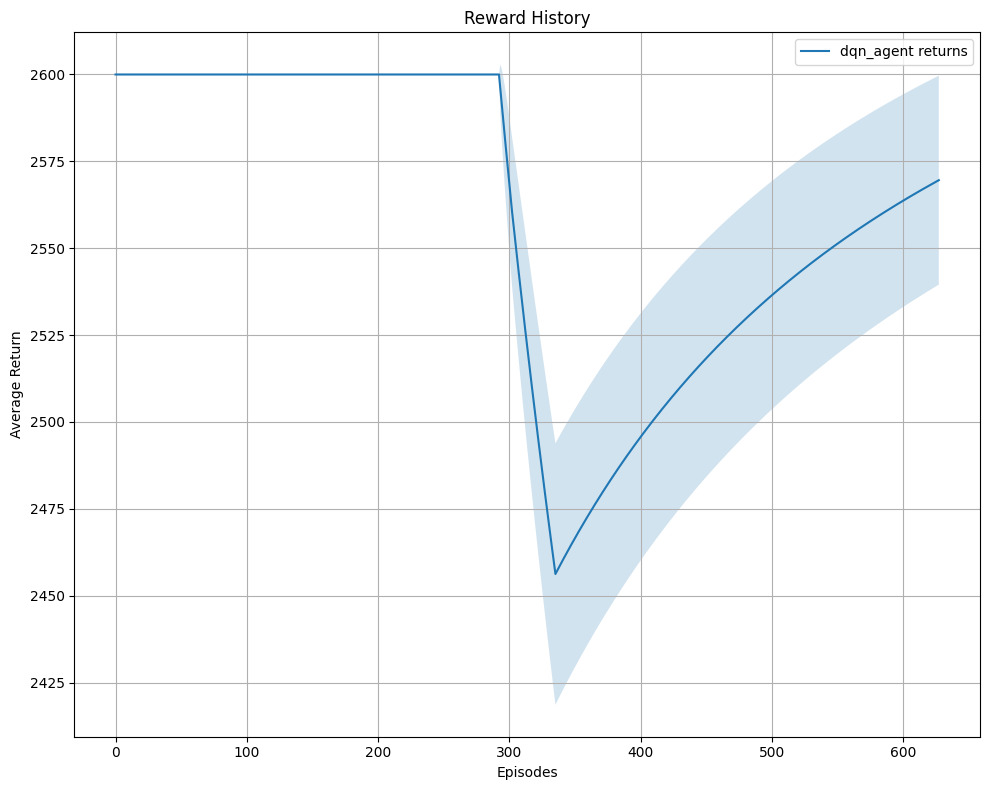

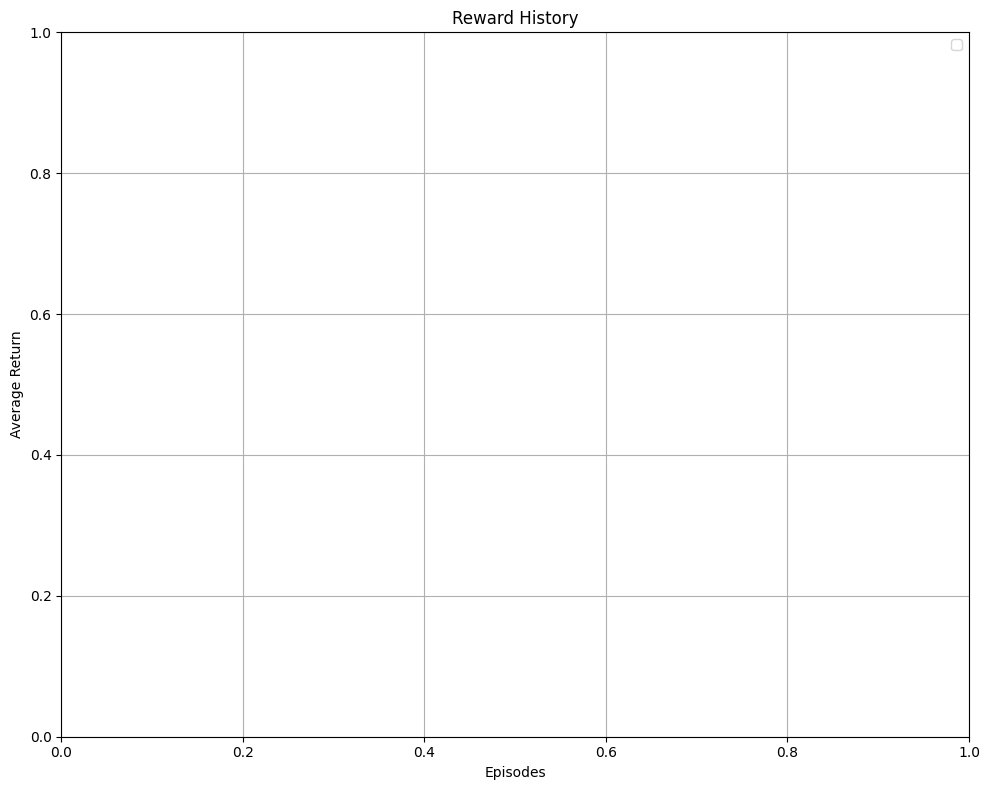

In [7]:
from notebooks.util.randomagentloop import run_random_gymnasium_loop

num_time_steps = 2500

model.learn(total_timesteps=num_time_steps, callback=SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_directory, agent_id="dqn_agent"))    # If you are training for a long time I would do it in a source file and not a jupyter notebook.
run_random_gymnasium_loop('ALE/DonkeyKong-v5', num_time_steps)

It is also useful to plot data from training. You could do this manually using some kind of callback perhaps, but Stable-baselines3 also has a buildin plotting function that works with the logger.

In [7]:
#from stable_baselines3.common import results_plotter
#
# Helper from the library
#results_plotter.plot_results(
#    [log_dir], 2500, results_plotter.X_TIMESTEPS, "DQN DonkeyKong"
#)

### Evaluating the DQN agent

Loading a pre-trained DQN agent:

In [8]:
model = DQN.load("./util/logs/best_model.zip")

/home/matthijs/programming/reinforcement-learning-rug/.venv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 5.54GB
  warnings.warn(


The most basic way to evaluate a RL agent is to get the average reward on a test environment after training. This can simply be done by having your agent interact with your environment after it has been trained. In Stable-Baselines3 there is an `evaluate-policy` function that can do this for you. It runs a policy for `n_eval_episodes` and returns the average reward.

Similar to the `learn` method, `evaluate-policy` also support callbacks, which means it can be customized.

In [9]:
from stable_baselines3.common.evaluation import evaluate_policy

test_env = make_atari_env("ALE/DonkeyKong-v5", n_envs=1, seed=0)
# Frame-stacking with 4 frames
test_env = VecFrameStack(test_env, n_stack=4)

mean_reward, std_reward = evaluate_policy(model, test_env, n_eval_episodes=20, warn=False)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward: 4085.00 +/- 85.29


### Game Recording

It is also a good idea to not look at just metrics and look at how the agent actually acts in the environment.
This can be important because of phenomena like "reward hacking" where the agent finds a policy that gives good rewards, but does not display the desired behavior.

Stable-baselines3 has functionality in place for recording your RL agent. This is done through the `VecVideoRecorder` class. It is also worth noting that this feature can be used also with your own custom RL agent.

In [10]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'
# !apt-get install ffmpeg freeglut3-dev xvfb  -y # For visualization

def record_video_atari(eval_env, model, video_length=500, prefix="", video_folder="videos/"):
    """
    :param eval_env: environment.
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env.metadata['render_fps'] = 60
    vec_env_record = VecVideoRecorder(eval_env,
                                      video_folder,
                                      record_video_trigger=lambda x: x == 0,    #  Function that defines when to start recording.
                                      video_length=video_length,
                                      name_prefix=prefix)

    obs = vec_env_record.reset()
    for _ in range(video_length + 1):
        action, _ = model.predict(obs)
        obs, _, _, _ = vec_env_record.step(action)

    # Close the video recorder
    vec_env_record.close()

In [11]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [12]:
record_video_atari(test_env, model, video_length=5000, prefix="dqn-dk")
show_videos("videos", prefix="dqn-dk")

/home/matthijs/programming/reinforcement-learning-rug/.venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
sh: 1: Xvfb: not found


Saving video to /home/matthijs/programming/reinforcement-learning-rug/notebooks/videos/dqn-dk-step-0-to-step-5000.mp4
Moviepy - Building video /home/matthijs/programming/reinforcement-learning-rug/notebooks/videos/dqn-dk-step-0-to-step-5000.mp4.
Moviepy - Writing video /home/matthijs/programming/reinforcement-learning-rug/notebooks/videos/dqn-dk-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /home/matthijs/programming/reinforcement-learning-rug/notebooks/videos/dqn-dk-step-0-to-step-5000.mp4
